In [1]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import dtlpy as dl
from dtlpy.ml import train_utils
%matplotlib inline  

# Get Global Model and Pretrained Snapshot

In [2]:
model = dl.models.get(model_name='ResNet')
snapshot = model.snapshots.get('pretrained-resnet18')
model.snapshots.list().to_df()

,id,creator,name,description,is_global,status,tags,configuration,modelId,projectId,datasetId,createdAt,bucket,ontologySpec
0,616d739d0682ca9d06c22225,yair@dataloop.ai,pretrained-resnet18,resnset18 pretrained on imagenet,True,created,"[pretrained, imagenet]","{'weights_filename': 'model.pth', 'classes_fil...",616d7360728ceffbb5b630b4,296bc0d5-46fc-447f-b3ee-25899e7268bc,None,2021-10-18T13:16:13.755Z,"{'type': 'gcs', 'gcsProjectName': 'viewo-main'...","{'labels': ['tench', 'goldfish', 'great white ..."


# Upload Dataset

In [4]:
project = dl.projects.get('Sheeps Face Proj')
dataset = project.datasets.create('Sheep Face')
dataset.to_df()

,id,name,annotated,creator,projects,itemsCount,driver,readableType,createdAt,accessLevel,readonly
0,61151cb9e5759208912b4e8e,Sheep Face,1680,or@dataloop.ai,[729659ec-6d7f-11e8-8d00-42010a8a002b],1681,rubiks_default_fs_driver,Master,2021-08-12T13:06:01.505Z,project,False


In [11]:
_ = dataset.items.upload(local_path='../../assets/sample_datasets/SheepFace/items/*',
                         local_annotations_path='../../assets/sample_datasets/SheepFace/json')


0it [00:00, ?it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1310/1681 [00:09<00:02, 166.64it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1681/1681 [00:11<00:00, 141.56it/s]


# Run Pretrained Model

In [4]:
adapter = model.build()

Load the pretrained snapshot into the model adapter

In [14]:
adapter.load_from_snapshot(snapshot=snapshot)

I: dtlpy.ml.base_model_adapter 09:44:08 [resnet_adapter.py:51](load):: Loading a model from C:\Users\Shabtay\.dataloop\snapshots\resnset50-imagenet-pretrained
I: dtlpy.ml.base_model_adapter 09:44:09 [resnet_adapter.py:56](load):: Loaded model from C:\Users\Shabtay\.dataloop\snapshots\resnset50-imagenet-pretrained\model.pth successfully


Get an item and predict with upload


predicting:   0%|                                                                                                                                                                                                   | 0/1 [00:00<?, ?bt/s]

  0%|                                                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]

predicting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/bt]
                                                        

Classification: analog clock


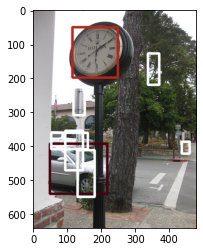

In [15]:
item = dl.items.get(item_id='611e174e4c09acc3c5bb81d3')
annotations = adapter.predict_items([item], with_upload=True)

image = Image.open(item.download())
plt.imshow(item.annotations.show(np.asarray(image),
                                 thickness=5))
print('Classification: {}'.format(annotations[0][0].label))

You can alos open the item in the platform to view and edit annotations easily

In [9]:
item.open_in_web()

# Train on new dataset
Here we will train on the Sheep dataset.  
First we will clone and split the dataset to 2 partitions - train and validation.  
After that we will clone the pretrained snapshot

In [5]:
dataset = project.datasets.get(dataset_name='Sheep Face')

partitions = {dl.SnapshotPartitionType.TRAIN: 0.8,
              dl.SnapshotPartitionType.VALIDATION: 0.2}
    
cloned_dataset = train_utils.prepare_dataset(dataset,
                                             filters=None,
                                             partitions=partitions)

snapshot_name='sheep-soft-augmentations'
# create an Item Bucket to save snapshot in your project
bucket = project.buckets.create(bucket_type=dl.BucketType.ITEM,                            
                                model_name=model.name,
                                snapshot_name=snapshot_name)
new_snapshot = snapshot.clone(snapshot_name=snapshot_name,
                              dataset_id=cloned_dataset.id,
                              bucket=bucket,
                              configuration={'batch_size': 16,
                                             'start_epoch': 0,
                                             'num_epochs': 2,
                                             'input_size': 256})

new_snapshot = model.snapshots.get(snapshot_name=snapshot_name)

2021-08-31 10:18:52.888 [WARNING]-[MainThread]-[v1.35.3]dtlpy.ml.train_utils: Cloned dataset already exist. Using it...
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                         | 0.00/97.8M [00:00<?, ?B/s]
  0%|                                                                                                                                                                                                 | 64.0k/97.8M [00:00<03:16, 520kB/s]
 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1/2 [00:01<00:01,  1.39s/it]
  1%|█▌                                                                                                                                                     

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86.7M/97.8M [00:07<00:00, 11.8MB/s]
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 87.8M/97.8M [00:07<00:00, 11.8MB/s]
 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 88.9M/97.8M [00:07<00:00, 11.8MB/s]
 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 90.1M/97.8M [00:07<00:00, 11.8MB/s]
 93%|███████████████████████████████████████████████████████

We will load the new cloned un-trained snapshot to the model adapter and prepare for trainin.  
This will download the dataset locally.

In [6]:
adapter.load_from_snapshot(snapshot=new_snapshot)

root_path, data_path, output_path = adapter.prepare_training()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1939.11it/s]
I: dtlpy.ml.base_model_adapter 10:19:22 [resnet_adapter.py:51](load):: Loading a model from C:\Users\Shabtay\.dataloop\snapshots\sheep-soft-augmentations
I: dtlpy.ml.base_model_adapter 10:19:23 [resnet_adapter.py:56](load):: Loaded model from C:\Users\Shabtay\.dataloop\snapshots\sheep-soft-augmentations\model.pth successfully
W: dtlpy.ml.base_model_adapter 10:19:24 [base_model_adapter.py:173](prepare_training):: Data path directory (C:\Users\Shabtay\.dataloop\datasets\612dd045ef3be2709836e286) is not empty..
2021-08-31 10:19:24.499 [WARNING]-[MainThread]-[v1.35.3]dtlpy.ml.base_model_adapter: Data path directory (C:\Users\Shabtay\.dataloop\datasets\612dd045ef3be2709836e286) is not empty..
100%|███████████████████████████████████████████████████████████████

# Create Dataoader and Visualize Images
We can Visualize the data with augmentation for debug and exploration.  
You can skip this part and go straight to training 

In [24]:
from imgaug import augmenters as iaa
from torchvision import transforms
from dtlpy.ml.ml_dataset import get_torch_dataset
augmentation = iaa.Sequential([
        iaa.Resize({"height": 256, "width": 256}),
        # iaa.Superpixels(p_replace=(0, 0.5), n_segments=(10, 50)),
        iaa.flip.Fliplr(p=0.5),
        iaa.flip.Flipud(p=0.5),
        iaa.GaussianBlur(sigma=(0.0, 0.8)),
    ])
tfs = transforms.Compose([
    augmentation,
    np.copy,
    # transforms.ToTensor()
])
dataloader = get_torch_dataset()(data_path=os.path.join(data_path, 'train'),
                                 dataset_entity=cloned_dataset,
                                 annotation_type=dl.AnnotationType.CLASSIFICATION,
                                 transforms=tfs)

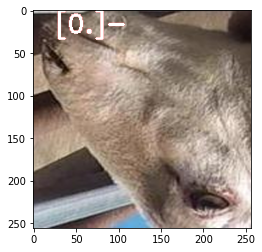

In [25]:
dataloader.visualize()

# Start The Train
Finally we are ready to train!

In [7]:
print("Training {!r} with snapshot {!r} on data {!r}".format(model.name, new_snapshot.id, data_path))

adapter.train(data_path=data_path,
              output_path=output_path)

Training 'ResNet-torch' with snapshot '612dd7dc3c18f7b46a8ba660' on data 'C:\\Users\\Shabtay\\.dataloop\\datasets\\612dd045ef3be2709836e286'


I: dtlpy.ml.base_model_adapter 10:19:35 [resnet_adapter.py:136](train):: Setting last layer for 4 classes
I: dtlpy.ml.base_model_adapter 10:19:35 [resnet_adapter.py:152](train):: Epoch 0/1  duration 0.02
I: dtlpy.ml.base_model_adapter 10:19:35 [resnet_adapter.py:153](train):: -------------------------

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]
I: dtlpy.ml.base_model_adapter 10:19:50 [resnet_adapter.py:195](train):: train Loss: 15.5995 Acc: 9.2976
I: dtlpy.ml.base_model_adapter 10:19:51 [resnet_adapter.py:195](train):: val Loss: 9.5070 Acc: 13.1905
I: dtlpy.ml.base_model_adapter 10:19:52 [resnet_adapter.py:152](train):: Epoch 1/1  duration 16.56
I: dtlpy.ml.base_model_adapter 10:19:52 [resnet_adapter.py:153](train):: -------------------------
I: dtlpy.ml.base_model_adapter 10:20:05 [resnet_adapter

Saving the snapshot - will upload the trained weights to the Item Bucket

In [10]:
adapter.save_to_snapshot(local_path=output_path,
                         replace=True)

0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                         | 0.00/90.0M [00:00<?, ?B/s]
 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1/2 [00:00<00:00,  2.63it/s]
  0%|▌                                                                                                                                                                                                 | 256k/90.0M [00:00<03:53, 402kB/s]
  1%|█▏                                                                                                                                                                                                | 576k/90.0M [00:00<02:54, 537kB/s]
  3%|██████▎                             

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 85.5M/90.0M [00:07<00:00, 12.8MB/s]
 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 87.1M/90.0M [00:07<00:00, 12.4MB/s]
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 88.5M/90.0M [00:07<00:00, 12.2MB/s]
90.1MB [00:08, 10.6MB/s]                                                                                                                                                                                                                  
100%|███████████████████████████████████████████████████████

In [10]:
adapter.snapshot.bucket.list_content()

['classes.json', 'model.pth']

# Predict On Out New Trained Snapshot
We will create a load and visualize the prediction of the snapshot

In [12]:
from imgaug import augmenters as iaa
from torchvision import transforms
from dtlpy.ml.ml_dataset import get_torch_dataset
augmentation = iaa.Sequential([
        iaa.Resize({"height": 256, "width": 256}),
        # iaa.Superpixels(p_replace=(0, 0.5), n_segments=(10, 50)),
        iaa.flip.Fliplr(p=0.5),
        iaa.flip.Flipud(p=0.5),
#         iaa.GaussianBlur(sigma=(0.0, 0.8)),
    ])
tfs = transforms.Compose([
    augmentation,
    np.copy,
    transforms.ToTensor()
])
dataloader = get_torch_dataset()(data_path=os.path.join(data_path, 'train'),
                                 dataset_entity=cloned_dataset,
                                 annotation_type=dl.AnnotationType.CLASSIFICATION,
                                 transforms=tfs,
                                 with_orig=True)

In [31]:
adapter = model.build()
trained_snapshot = model.snapshots.get(snapshot_name='sheep-soft-augmentations')
adapter.load_from_snapshot(snapshot=trained_snapshot,
                          overwrite=True)

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1/2 [00:00<00:00,  7.28it/s]
  0%|                                                                                                                                                                                                         | 0.00/90.0M [00:00<?, ?B/s]
  0%|                                                                                                                                                                                                 | 48.0k/90.0M [00:00<03:20, 471kB/s]
  0%|▎                                                                                                                                                                                                 | 168k/90.0M [00:00<02:43, 576kB/s]
  0%|▊                                                      

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 73.2M/90.0M [00:07<00:01, 9.44MB/s]
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 74.3M/90.0M [00:07<00:01, 9.99MB/s]
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 75.3M/90.0M [00:07<00:01, 9.02MB/s]
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 76.9M/90.0M [00:08<00:01, 10.5MB/s]
 87%|███████████████████████████████████████████████████████

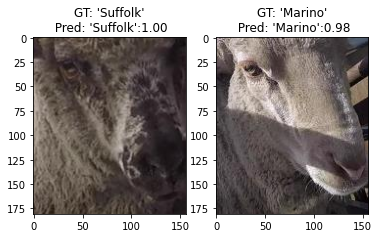

In [33]:
fig, ax = plt.subplots(1,2)
for i in range(2):
    image, target, orig_image, orig_targets = dataloader[np.random.randint(len(dataloader))]
    anno = adapter.predict([orig_image])
    ax[i].imshow(orig_image)
    ax[i].set_title('GT: {!r}\n Pred: {!r}:{:.2f}'.format(adapter.label_map[str(int(target))],
                                                          anno[0][0].label,
                                                          anno[0][0].metadata['user']['model']['confidence']))

# Predict and Upload Annotation to Item in Platform
We will get an item from the dataset and predict with the new sheeps snapshot

In [37]:
dataset.items.list().to_df()

,createdAt,datasetId,annotated,filename,name,type,id,hidden,dir,annotationsCount,dataset
0,2021-08-12T13:06:09.000Z,61151cb9e5759208912b4e8e,True,/Poll Dorset/000342 P.jpg,000342 P.jpg,file,61151cc1b8cf83f7c2c23325,False,/Poll Dorset,1,https://gate.dataloop.ai/api/v1/datasets/61151...
1,2021-08-12T13:06:09.000Z,61151cb9e5759208912b4e8e,True,/Poll Dorset/000287 P.jpg,000287 P.jpg,file,61151cc1b8cf83a935c2330a,False,/Poll Dorset,1,https://gate.dataloop.ai/api/v1/datasets/61151...
2,2021-08-12T13:06:09.000Z,61151cb9e5759208912b4e8e,True,/Poll Dorset/000198 P.jpg,000198 P.jpg,file,61151cc1b8cf839f5fc232f2,False,/Poll Dorset,1,https://gate.dataloop.ai/api/v1/datasets/61151...
3,2021-08-12T13:06:09.000Z,61151cb9e5759208912b4e8e,True,/Poll Dorset/000251 P.jpg,000251 P.jpg,file,61151cc1b8cf838597c23303,False,/Poll Dorset,1,https://gate.dataloop.ai/api/v1/datasets/61151...
4,2021-08-12T13:06:09.000Z,61151cb9e5759208912b4e8e,True,/Poll Dorset/000331 P.jpg,000331 P.jpg,file,61151cc1b8cf83816fc23321,False,/Poll Dorset,1,https://gate.dataloop.ai/api/v1/datasets/61151...
...,...,...,...,...,...,...,...,...,...,...,...
995,2021-08-12T13:06:16.000Z,61151cb9e5759208912b4e8e,True,/White Suffolk/crop007423WB1.jpg,crop007423WB1.jpg,file,61151cc851ab374b4d1e1531,False,/White Suffolk,1,https://gate.dataloop.ai/api/v1/datasets/61151...
996,2021-08-12T13:06:16.000Z,61151cb9e5759208912b4e8e,True,/White Suffolk/crop000086WA5.jpg,crop000086WA5.jpg,file,61151cc8379ab27a09ecf3b2,False,/White Suffolk,1,https://gate.dataloop.ai/api/v1/datasets/61151...
997,2021-08-12T13:06:16.000Z,61151cb9e5759208912b4e8e,True,/White Suffolk/crop001014WA2.jpg,crop001014WA2.jpg,file,61151cc8287433ad774a146f,False,/White Suffolk,1,https://gate.dataloop.ai/api/v1/datasets/61151...
998,2021-08-12T13:06:16.000Z,61151cb9e5759208912b4e8e,True,/White Suffolk/89.jpgWA7.jpg,89.jpgWA7.jpg,file,61151cc82874339b3f4a146c,False,/White Suffolk,1,https://gate.dataloop.ai/api/v1/datasets/61151...


predicting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37bt/s]
I: dtlpy.ml.base_model_adapter 11:45:36 [base_model_adapter.py:288](predict_items):: Uploading  items annotation for snapshot 'sheep-soft-augmentations'. cleanup False
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


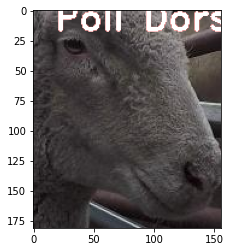

In [40]:
item = dataset.items.get(filepath='/Poll Dorset/000342 P.jpg')
annotations = adapter.predict_items([item], with_upload=True)
image = Image.open(item.download())
plt.imshow(item.annotations.show(np.asarray(image),
                                 with_text=True))
